# Time-series prediction example

This notebook shows a simple way to predict time series data using a MLP neural network. 
The data is hourly weather data from Meteostat. 

For sake of simplicity and easy testing and debugging the code is implemented mostly as a script and only minimum amount of functions and classes are implemented. 

(c) Mikko Kursula 2021. MIT License. 

In [1]:
# General
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data source
import meteostat

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get input data and define the training target
Data is queries using a target location. First the weather station is selected and then the data is loaded. 

In [2]:
stations = meteostat.Stations()
stations = stations.nearby(lat=61.4167, lon=23.5833)
station = stations.fetch(3)
station.head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,distance
id,,,,,,,,,,,,,,
02944,Tampere / Pirkkala,FI,<NA>,02944,EFTP,61.4167,23.5833,112.0,Europe/Helsinki,1906-01-01,2021-11-19,1979-11-01,NaT,0.000000
02763,Tampere Harmala / Lakalaiva,FI,<NA>,02763,<NA>,61.4667,23.7500,85.0,Europe/Helsinki,2008-01-15,2021-10-08,2008-01-17,NaT,10461.024472
02943,Tampere / Onkiniemi,FI,<NA>,02943,EFTA,61.5167,23.7500,98.0,Europe/Helsinki,1973-01-01,2021-10-08,2008-01-17,NaT,14214.060197


In [3]:
station_id = '02944'
start_dt = datetime(1990, 1, 1)
end_dt = datetime(2021, 11, 1)

In [3]:
# Get hourly data
raw_data = meteostat.Hourly(station_id, start_dt, end_dt)
raw_data = raw_data.fetch()
raw_data.to_parquet('dataset.parquet')

### Read the data from file 
Use this if the data has been obtained and stored earlier

In [4]:
raw_data = pd.read_parquet('dataset.parquet')

In [5]:
raw_data.sample(10)

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2017-05-26 10:00:00,15.0,2.8,44.0,NaN,NaN,320.0,18.4,NaN,1014.2,NaN,NaN
2015-11-02 10:00:00,9.8,7.6,86.0,NaN,NaN,250.0,21.6,NaN,1011.1,NaN,NaN
2004-04-13 16:00:00,7.0,-9.0,31.0,NaN,NaN,290.0,11.2,NaN,NaN,NaN,NaN
2018-05-19 09:00:00,15.0,-2.0,31.0,NaN,NaN,340.0,11.2,NaN,1020.5,NaN,1.0
1994-11-05 01:00:00,0.0,-1.0,93.0,NaN,NaN,180.0,11.2,NaN,NaN,NaN,NaN
2001-04-14 04:00:00,-5.0,-13.1,53.0,NaN,NaN,10.0,11.2,NaN,NaN,NaN,NaN
2010-09-17 10:00:00,13.6,9.4,76.0,NaN,NaN,140.0,14.4,NaN,996.4,NaN,NaN
2015-04-06 02:00:00,-4.5,-4.8,98.0,NaN,NaN,NaN,NaN,NaN,1025.7,NaN,NaN
1995-03-07 12:00:00,2.8,0.4,84.0,NaN,NaN,170.0,16.6,NaN,1008.0,NaN,NaN


# Data exploration and fixing

### Pick the columns to be explored

In [6]:
columns = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']

### Calculate continous datetime index and fill any gaps in data

In [7]:
def gap_fill(raw_data : pd.DataFrame, 
             start_dt : datetime, 
             end_dt : datetime, 
             columns : list
            ) -> pd.DataFrame:
    
    new_index = pd.date_range(start_dt, end_dt, freq='1h')
    proc_data = pd.DataFrame(index=new_index)
    proc_data = pd.merge(proc_data, raw_data[columns], left_index=True, right_index=True, how='left')
    
    # prcp is sparse and will get zero filling
    if 'prcp' in columns:
        proc_data['prcp'] = proc_data['prcp'].fillna(0)

    # Count number of missing values and fill the gaps 
    for col in columns: 
        n_missing = pd.isnull(proc_data[col]).sum()
        print('{}: missing {:0.3f}% of values'.format(col, n_missing / proc_data.shape[0]))
        proc_data[col] = proc_data[col].fillna(method='ffill')
    
    return proc_data

In [8]:
dataset = gap_fill(raw_data, start_dt, end_dt, columns)

temp: missing 0.056% of values
dwpt: missing 0.060% of values
rhum: missing 0.060% of values
prcp: missing 0.000% of values
wdir: missing 0.137% of values
wspd: missing 0.073% of values
pres: missing 0.387% of values


### Inspect data
Correlation between temp and lagged signals is used to find if something in the signals can predict temp values. 
Especially correlation at positive lag values indicate predictive features. 
Autocorrelation, i.e. correlation between temp and lagged temp, gives information about the possibility of using temp values to predict the future temp values. 

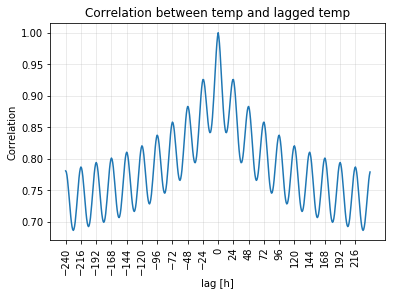

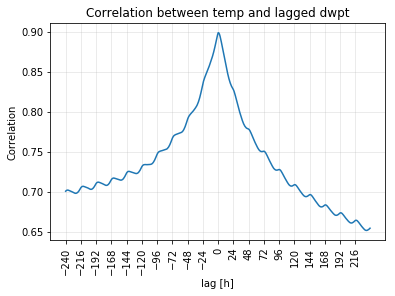

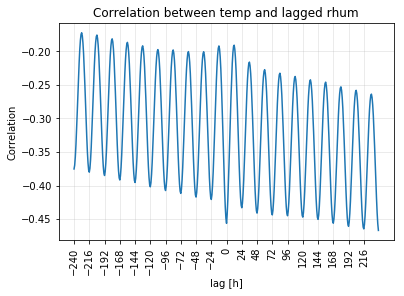

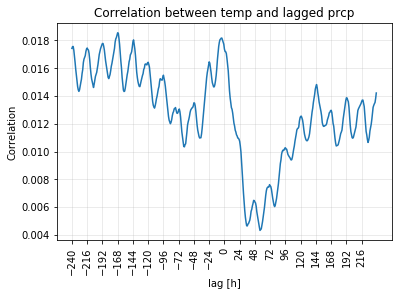

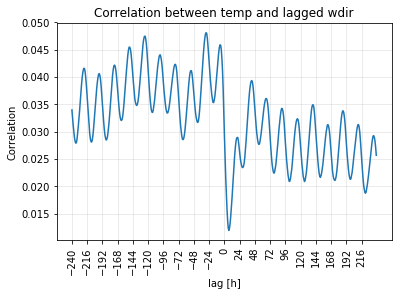

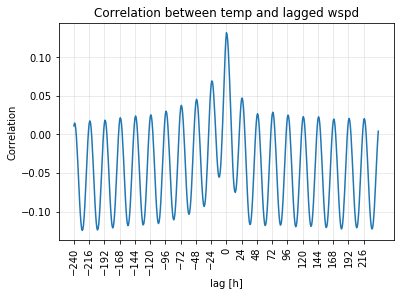

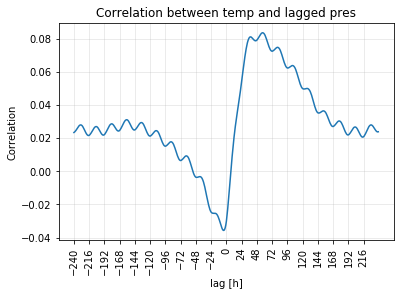

In [9]:
target_col = 'temp'
for col in columns: 
    corr_values = []
    x = []
    lags = np.arange(-240, 240)
    for lag in lags: 
        corr = dataset[target_col].corr(dataset[col].shift(lag))
        corr_values.append(corr)
        x.append(lag)

    plt.plot(x, corr_values)
    plt.ylabel('Correlation')
    plt.xlabel('lag [h]')
    plt.title('Correlation between {} and lagged {}'.format(target_col, col))
    plt.xticks(x[::24], rotation=90)
    plt.grid(alpha=0.3)
    plt.show()

### Plot some sequence samples

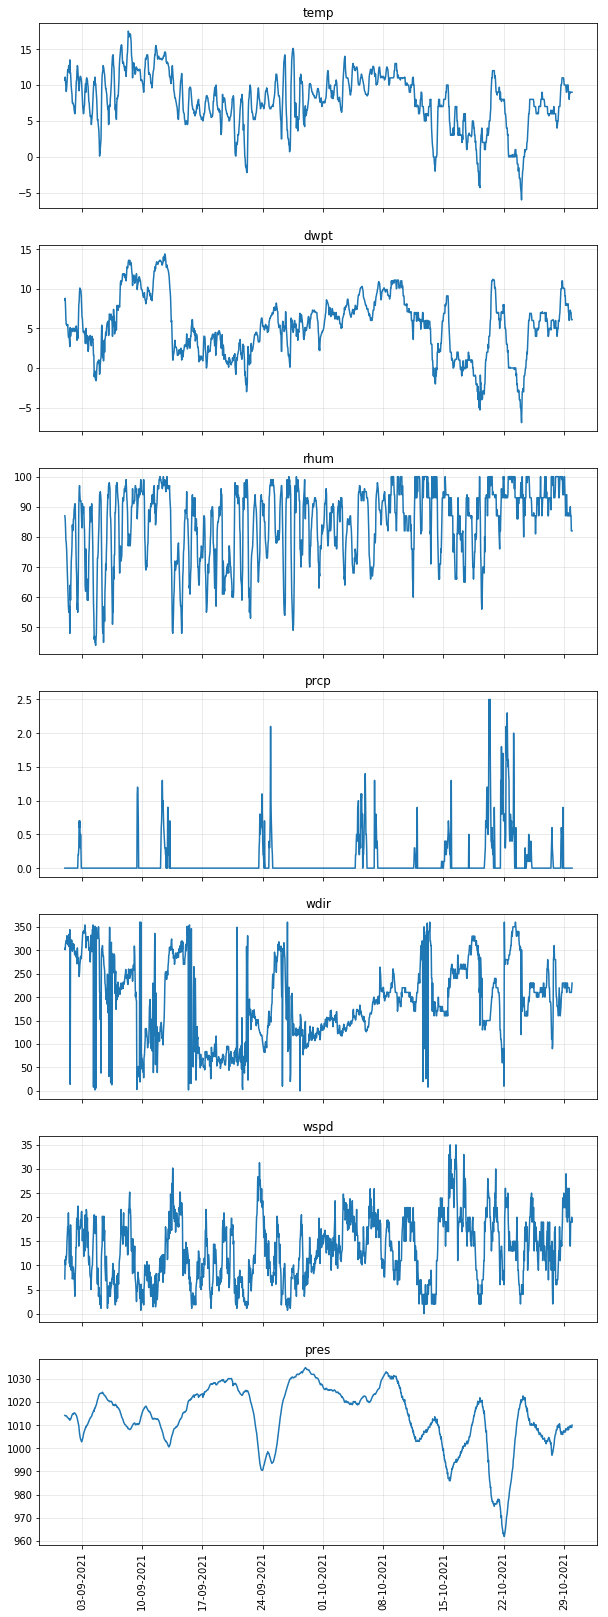

In [10]:
# Pick time range for the plot 
plot_start = datetime(2021, 9, 1)
plot_end = datetime(2021, 10, 30)

mask = (dataset.index >= plot_start) & (dataset.index < plot_end)
fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(10, 4 * len(columns)))
for i, col in enumerate(columns):
    ax = axs[i]
    ax.plot(dataset.loc[mask, col])
    ax.set_title(col)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax.tick_params(axis='x', labelrotation=90)

plt.show()

# Setup ML model parameters
Select input and target signals, sequence lengths etc. 

In [11]:
params = dict(
    inputs = ['temp', 'dwpt', 'rhum', 'prcp', 'pres'], 
    target = 'temp',
    input_len = 10 * 24,
    target_len = 24,
    stepping = 24, 
    train_test_ratio = 0.8,
    batch_size = 64,
    epochs = 30,
)

# Training dataset creation

In [12]:
class DataProcessing: 
    # Simple class for data preprocessing and postprocessing. 
    # Preprocessing will scale data to [0, 1] range. 
    # Postprocessing will scale data back to the original range. 
    
    def __init__(self, target : str, inputs : list): 
        self.min_values = {}
        self.max_values = {}
        self.target = target
        self.inputs = inputs

        
    def fit_params(self, dataset : pd.DataFrame) -> None: 
        columns = self.inputs
        if self.target not in columns: 
            columns.append(self.target)
            
        for col in columns: 
            self.min_values[col] = dataset[col].min()
            self.max_values[col] = dataset[col].max()

            
    def preprocess(self, dataset : pd.DataFrame) -> pd.DataFrame: 
        scaled = dataset.copy()
        for col in self.inputs: 
            scaled[col] = (scaled[col] - self.min_values[col]) / (self.max_values[col] - self.min_values[col])
        return scaled[self.inputs]
        
        
    def postprocess(self, data, col : str): 
        data = data * (self.max_values[col] - self.min_values[col]) + self.min_values[col]
        return data
    
    
def format_inputs(data : np.ndarray) -> torch.Tensor:
    in_values = torch.from_numpy(data).float().permute(1, 0)
    return in_values


def format_target(data : np.ndarray) -> torch.Tensor:
    target_values = torch.from_numpy(data).float()
    return target_values
    
    
def create_training_samples(dataset : pd.DataFrame, params : dict):
    samples = []
    sample_idxs = []
    sample_dates = []
    sample_count = int((dataset.shape[0] - params['input_len'] - params['target_len']) / params['stepping'])
    
    for sample_idx in range(sample_count): 
        in_start_i = sample_idx * params['stepping']
        in_start = dataset.index[in_start_i]        
        in_end_i = in_start_i + params['input_len'] - 1
        in_end = dataset.index[in_end_i]
        in_values = dataset.loc[in_start : in_end, params['inputs']].values
        in_values = format_inputs(in_values)

        target_start_i = in_end_i + 1
        target_start = dataset.index[target_start_i]
        target_end_i = target_start_i + params['target_len'] - 1
        target_end = dataset.index[target_end_i]
        target_values = dataset.loc[target_start : target_end, params['target']].values
        target_values = format_target(target_values)
        
        samples.append([in_values, target_values])
        sample_idxs.append(target_start)
        sample_dates.append([in_start, in_end, target_start, target_end])
        
    return samples, sample_idxs, sample_dates

data_proc = DataProcessing(target=params['target'], inputs=params['inputs'])
data_proc.fit_params(dataset)
preproc = data_proc.preprocess(dataset)
samples, sample_idxs, sample_dates = create_training_samples(preproc, params)

split_idx = int(len(samples) * params['train_test_ratio'])
train_loader = torch.utils.data.DataLoader(samples[:split_idx], batch_size=params['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(samples[split_idx:], batch_size=params['batch_size'], shuffle=False)

# Setup neural network model

In [13]:
class Net(nn.Module):
    def __init__(self, params : dict):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(params['input_len'] * len(params['inputs']), 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, params['target_len'])
        
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        output = self.fc3(x)
        return output
    
    
def train(model, train_loader, optimizer, loss_func):
    losses = []
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def test(model, test_loader, loss_func):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = loss_func(output, target)
            losses.append(loss.item())
    return np.mean(losses)

In [14]:
model = Net(params)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

train_losses = []
test_losses = []
for epoch in range(params['epochs']):
    train_loss = train(model, train_loader, optimizer, loss_func)
    test_loss = test(model, test_loader, loss_func)

    print('epoch: {:3}, train loss: {:0.5f}, test loss: {:0.5f}'.format(epoch, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

epoch:   0, train loss: 0.04297, test loss: 0.00623
epoch:   1, train loss: 0.00494, test loss: 0.00385
epoch:   2, train loss: 0.00410, test loss: 0.00351
epoch:   3, train loss: 0.00377, test loss: 0.00325
epoch:   4, train loss: 0.00341, test loss: 0.00286
epoch:   5, train loss: 0.00310, test loss: 0.00262
epoch:   6, train loss: 0.00295, test loss: 0.00246
epoch:   7, train loss: 0.00274, test loss: 0.00234
epoch:   8, train loss: 0.00262, test loss: 0.00220
epoch:   9, train loss: 0.00252, test loss: 0.00212
epoch:  10, train loss: 0.00248, test loss: 0.00209
epoch:  11, train loss: 0.00238, test loss: 0.00217
epoch:  12, train loss: 0.00231, test loss: 0.00195
epoch:  13, train loss: 0.00229, test loss: 0.00190
epoch:  14, train loss: 0.00222, test loss: 0.00187
epoch:  15, train loss: 0.00217, test loss: 0.00195
epoch:  16, train loss: 0.00216, test loss: 0.00201
epoch:  17, train loss: 0.00215, test loss: 0.00180
epoch:  18, train loss: 0.00210, test loss: 0.00178
epoch:  19, 

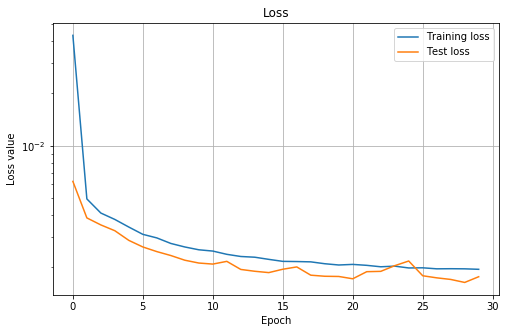

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Evaluate

### Plot prediction sample

9350


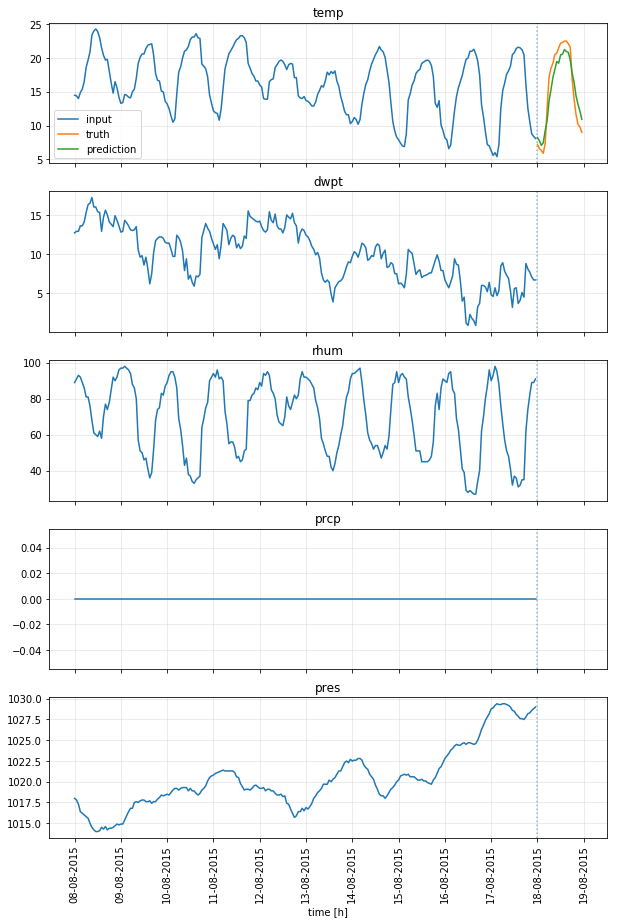

In [18]:
# Select sample from test data
idx = np.random.randint(int(len(samples) * params['train_test_ratio']), len(samples) - 1)
print(idx)

model.eval()
prediction = model(samples[idx][0].unsqueeze(0)).detach()[0]
prediction = data_proc.postprocess(prediction, params['target']) 
truth = data_proc.postprocess(samples[idx][1][:], params['target']) 

# Plot
fig, axs_temp = plt.subplots(
    nrows=len(params['inputs']), 
    ncols=1, 
    sharex=True, 
    figsize=(10, 3 * len(params['inputs']))
)
if type(axs_temp) != np.ndarray: 
    axs_temp = [axs_temp]
axs = {}
for i, col in enumerate(params['inputs']):
    axs[col] = axs_temp[i]
    
in_x = pd.date_range(sample_dates[idx][0], sample_dates[idx][1], freq='1h')
pred_x = pd.date_range(sample_dates[idx][2], sample_dates[idx][3], freq='1h')
xticks = pd.date_range(sample_dates[idx][0], sample_dates[idx][3] + timedelta(hours=1), freq='1d')

# Inputs 
for i, col in enumerate(params['inputs']):
    ax = axs[col]
    in_y = data_proc.postprocess(samples[idx][0][i, :], col) 
    ax.plot(in_x.values, in_y, label='input')
    ax.set_title(col)
    ax.axvline(pred_x[0], ls=':', alpha=0.5)
    ax.set_xticks(xticks)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax.tick_params(axis='x', labelrotation=90)


# Prediction 
ax = axs[params['target']]
ax.plot(pred_x.values, truth, label='truth')
ax.plot(pred_x.values, prediction, label='prediction')
ax.legend()

plt.xlabel('time [h]')
plt.show()

### Error statistics

In [19]:
test_start_idx = int(len(samples) * params['train_test_ratio'])
mae = []
dates = []
hourly_errors = []

model.eval()
for idx in range(test_start_idx, len(samples)):
    with torch.no_grad():
        pred = model(samples[idx][0].unsqueeze(0)).detach()[0]
    pred = data_proc.postprocess(pred, params['target']) 
    truth = data_proc.postprocess(samples[idx][1][:], params['target']) 
    
    error = np.mean(np.abs(pred.numpy() - truth.numpy()))
    mae.append(error)
    dates.append(sample_idxs[idx])
    
    hourly_errors.append(pred.numpy() - truth.numpy())

hourly_errors = np.array(hourly_errors)
err_df = pd.DataFrame(index=dates, data={'error' : mae})
err_df['month'] = err_df.index.month

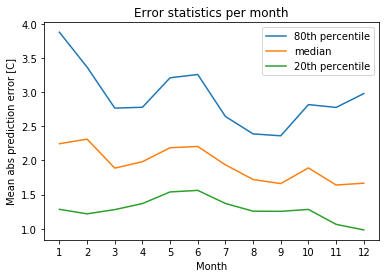

In [20]:
agg = err_df.groupby('month')['error'].quantile(0.8)
plt.plot(agg.index.values, agg.values, label='80th percentile')

agg = err_df.groupby('month')['error'].median()
plt.plot(agg.index.values, agg.values, label='median')

agg = err_df.groupby('month')['error'].quantile(0.2)
plt.plot(agg.index.values, agg.values, label='20th percentile')

plt.xticks(np.arange(1, 13))
plt.legend()
plt.title('Error statistics per month')
plt.ylabel('Mean abs prediction error [C]')
plt.xlabel('Month')
plt.show()

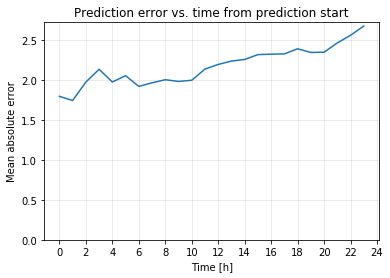

In [21]:
plt.plot(np.mean(np.abs(hourly_errors), axis=0))
plt.grid(alpha=0.3)
plt.title('Prediction error vs. time from prediction start')
plt.ylabel('Mean absolute error')
plt.xlabel('Time [h]')
plt.xticks(np.arange(0, params['target_len'] + 1, 2))
plt.ylim(0)
plt.show()

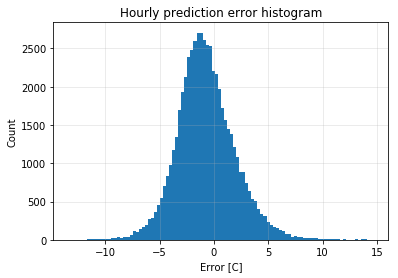

In [22]:
plt.hist(hourly_errors.flatten(), bins=100)
plt.grid(alpha=0.3)
plt.title('Hourly prediction error histogram')
plt.ylabel('Count')
plt.xlabel('Error [C]')
plt.show()

### Error vs time 
This runs predictions for longer sequence. 

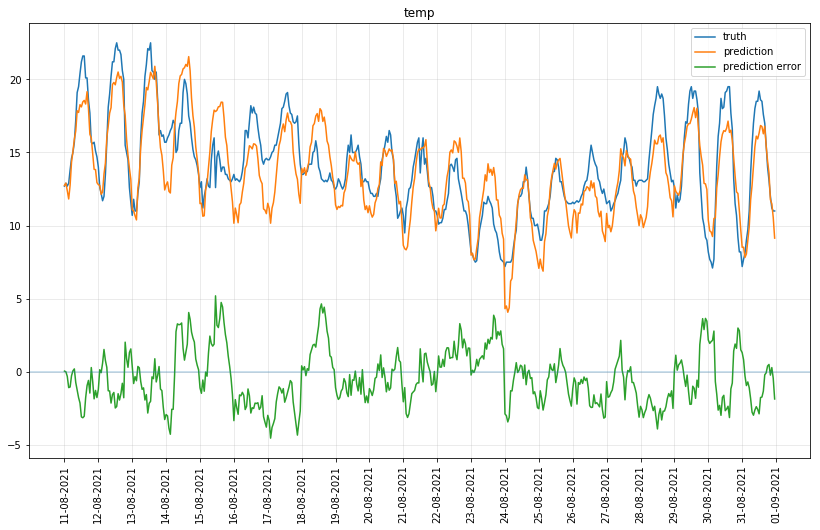

In [23]:
# Pick time range for the test 
plot_start = datetime(2021, 8, 1)
plot_end = datetime(2021, 9, 1)

predictions = []
truths = []
dates = []

# Define the starting points for slices that are used in predictions
slice_starts = pd.date_range(
    plot_start, 
    plot_end - timedelta(hours=params['input_len'] + params['target_len']),
    freq='{}h'.format(params['target_len'])
)

# Make prediction for each slide
for slice_start in slice_starts: 
    # Parse input data
    slice_end = slice_start + timedelta(hours=params['input_len'])
    mask = (dataset.index >= slice_start) & (dataset.index < slice_end)
    inf_data = dataset.loc[mask, params['inputs']]
    inf_input = data_proc.preprocess(inf_data).values
    inf_input = format_inputs(inf_input)

    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = model(inf_input.unsqueeze(0)).detach()[0]
    prediction = data_proc.postprocess(prediction, params['target']) 
    predictions.extend(prediction)
    
    # Parse also the truth and datetime values 
    mask = (dataset.index >= slice_end) & (dataset.index < slice_end + timedelta(hours=params['target_len']))    
    truths.extend(dataset.loc[mask, params['target']])
    dates.extend(dataset.index[mask])
    
dates = pd.to_datetime(dates)
residuals = np.array(predictions) - np.array(truths)

# Plot results. The input sequence from beginning of the time range is omitted, since there are no predictions. 
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(14, 8))

ax.plot(dates.values, truths, label='truth')
ax.plot(dates.values, predictions, label='prediction')
ax.grid(alpha=0.3)
ax.plot(dates.values, residuals, label='prediction error')
ax.axhline(0, alpha=0.3)
ax.set_xticks(pd.date_range(min(dates), max(dates) + timedelta(hours=1), freq='1d'))
ax.grid(alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.tick_params(axis='x', labelrotation=90)
ax.legend()
ax.set_title(params['target'])
plt.show()

### TODO
- save model and parameters to file 
- load model and parameters from file

# Inference example
Query the latest data and make a prediction

temp: missing 0.000% of values
dwpt: missing 0.000% of values
rhum: missing 0.000% of values
prcp: missing 0.000% of values
pres: missing 0.000% of values


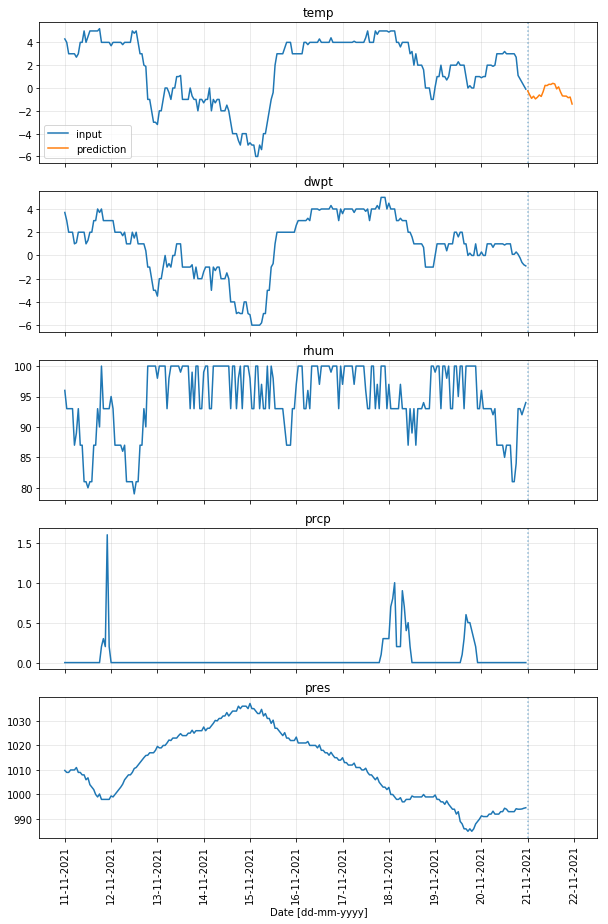

In [24]:
# Set query params
station_id = '02944'
inf_start_dt = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(hours=params['input_len'])
inf_end_dt = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(hours=1)

# Get hourly data
inf_data = meteostat.Hourly(station_id, inf_start_dt, inf_end_dt)
inf_data = inf_data.fetch() 

# Process the data
inf_data = gap_fill(inf_data, inf_start_dt, inf_end_dt, params['inputs'])
inf_input = data_proc.preprocess(inf_data)
inf_input = inf_input[params['inputs']].values
inf_input = format_inputs(inf_input)

# Make prediction
model.eval()
with torch.no_grad():
    prediction = model(inf_input.unsqueeze(0)).detach()[0]
prediction = data_proc.postprocess(prediction, params['target']) 

# Plot
fig, axs_temp = plt.subplots(
    nrows=len(params['inputs']), 
    ncols=1, 
    sharex=True, 
    figsize=(10, 3 * len(params['inputs']))
)
if type(axs_temp) != np.ndarray: 
    axs_temp = [axs_temp]
axs = {}
for i, col in enumerate(params['inputs']):
    axs[col] = axs_temp[i]
    
# Create x values
x_ticks = pd.date_range(inf_start_dt, inf_end_dt + timedelta(hours=params['target_len'] + 1) , freq='1d')
pred_x = pd.date_range(
    inf_end_dt + timedelta(hours=1), 
    inf_end_dt + timedelta(hours=params['target_len']), 
    freq='1h'
)

# Plot inputs 
for i, col in enumerate(params['inputs']):
    ax = axs[col]
    ax.plot(inf_data.index.values, inf_data[col].values, label='input')
    ax.set_title(col)
    ax.axvline(pred_x[0], ls=':', alpha=0.5)
    ax.set_xticks(x_ticks)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax.tick_params(axis='x', labelrotation=90)
    
# Plot prediction 
ax = axs[params['target']]
ax.plot(pred_x.values, prediction, label='prediction')
ax.legend()

plt.xlabel('Date [dd-mm-yyyy]')
plt.show()